# Part 1 | Augmented Reality

## Importing Libraries

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from util.loadVid  import loadVid

In [4]:
import sys
sys.path.append('..')
from common import *

## Reading the cover image

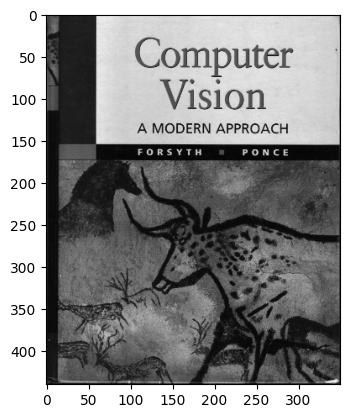

In [5]:
cover = cv2.imread('assets/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(cover, cmap='gray')